In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output

Next, the data loader

Training samples: 140
Validation samples: 30
Testing samples: 30


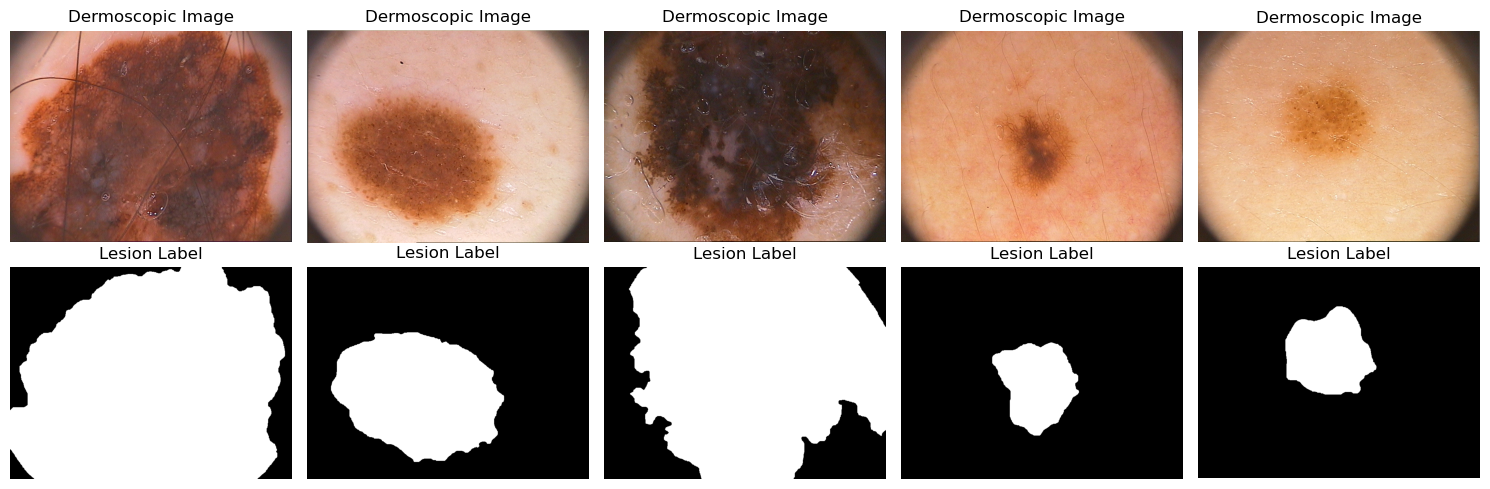

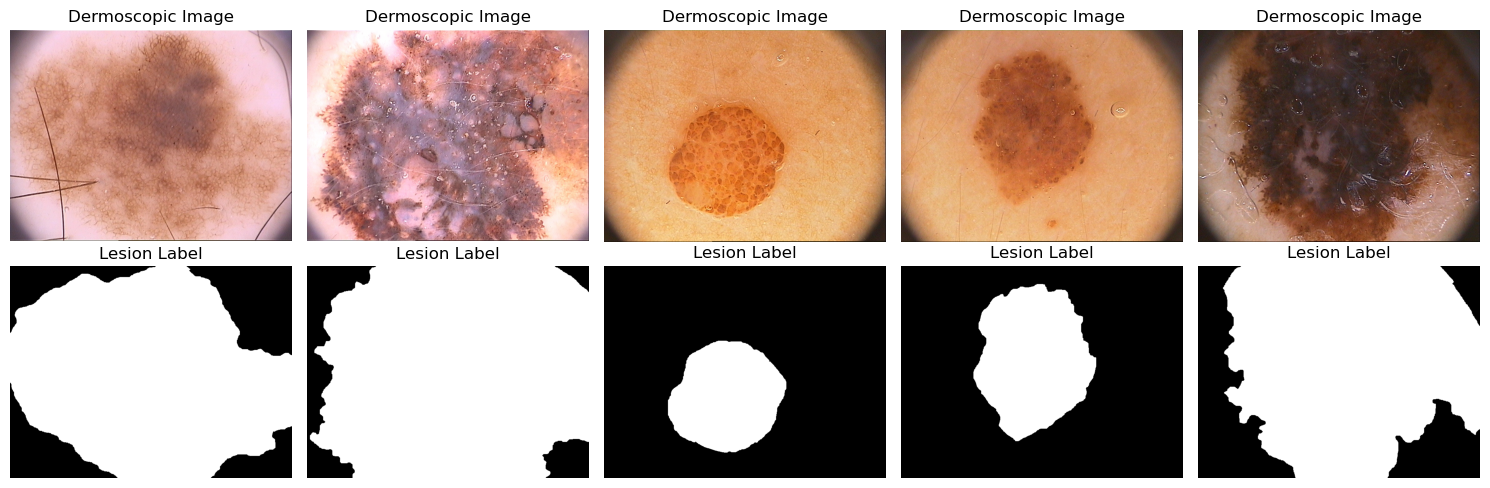

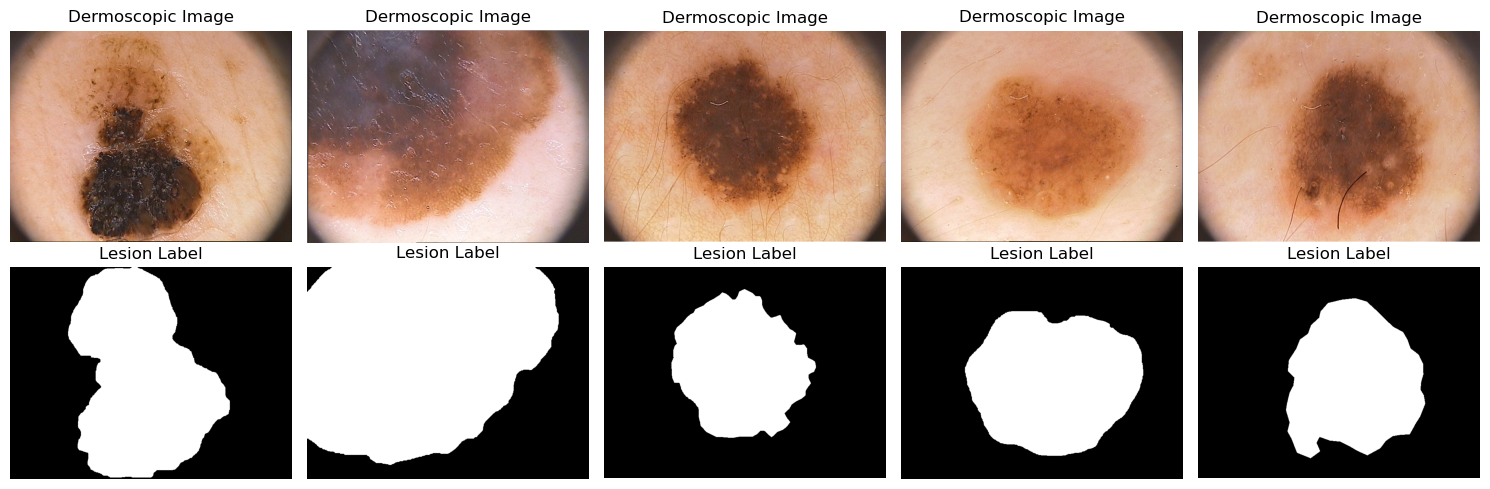

In [2]:
import os
import glob
import random
from PIL import Image
import torch
from torch.utils.data import Dataset

class SkinLesionLoader(Dataset):
    def __init__(self, transform, dataset_path, split='train'):
        'Initialization'
        self.transform = transform
        
        # Collect all image paths and label paths
        self.image_paths = []
        self.label_paths = []

        # Loop through all IMG### folders
        for folder_name in os.listdir(dataset_path):
            folder_path = os.path.join(dataset_path, folder_name)
            if os.path.isdir(folder_path):
                # Add dermoscopic image path
                dermoscopic_image_path = os.path.join(folder_path, f'{folder_name}_Dermoscopic_Image', f'{folder_name}.bmp')
                if os.path.exists(dermoscopic_image_path):
                    self.image_paths.append(dermoscopic_image_path)
                
                # Add lesion image path
                lesion_image_path = os.path.join(folder_path, f'{folder_name}_lesion', f'{folder_name}_lesion.bmp')
                if os.path.exists(lesion_image_path):
                    self.label_paths.append(lesion_image_path)

        # Ensure both lists have the same length
        assert len(self.image_paths) == len(self.label_paths), "Image and label counts do not match."

        # Randomly shuffle the dataset
        combined = list(zip(self.image_paths, self.label_paths))
        random.shuffle(combined)
        self.image_paths, self.label_paths = zip(*combined)

        # Split indices for 70-15-15
        total_len = len(self.image_paths)
        train_split = int(total_len * 0.7)
        val_split = int(total_len * 0.85)  # 70% for training, next 15% for validation

        if split == 'train':
            self.image_paths = self.image_paths[:train_split]
            self.label_paths = self.label_paths[:train_split]
        elif split == 'val':
            self.image_paths = self.image_paths[train_split:val_split]
            self.label_paths = self.label_paths[train_split:val_split]
        elif split == 'test':
            self.image_paths = self.image_paths[val_split:]
            self.label_paths = self.label_paths[val_split:]
        else:
            raise ValueError("Invalid split name. Use 'train', 'val', or 'test'.")

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format
        label = Image.open(label_path).convert("L")    # Ensure label is in grayscale
        
        X = self.transform(image)
        Y = self.transform(label)
        
        return X, Y

# Usage
data_path = "/dtu/datasets1/02516//PH2_Dataset_images"
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size
    transforms.ToTensor()             # Convert to tensor
])

# Create dataset instances for train, validation, and test
train_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='train')
val_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='val')
test_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='test')

# Optional: Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

def display_image_pairs(dataset, n_samples=5):
    sampled_indices = random.sample(range(len(dataset)), min(n_samples, len(dataset)))
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sampled_indices):
        # Get image and label
        image_path = dataset.image_paths[idx]
        label_path = dataset.label_paths[idx]
        
        # Open images
        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path).convert("L")  # Convert label to grayscale
        
        # Display images
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(image)
        plt.title("Dermoscopic Image")
        plt.axis("off")
        
        plt.subplot(2, n_samples, i + 1 + n_samples)
        plt.imshow(label, cmap='gray')
        plt.title("Lesion Label")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Display random pairs from the training dataset
display_image_pairs(train_dataset, n_samples=5)
display_image_pairs(val_dataset, n_samples=5)
display_image_pairs(test_dataset, n_samples=5)


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [22]:
def check_data_structure(data_path):
    for root, dirs, files in os.walk(data_path):
        # Print current directory path
        print(f"Directory: {root}")
        
        # Print subdirectories
        for subdir in dirs:
            print(f"  Subdirectory: {subdir}")
        
        # Print files
        for file in files:
            print(f"  File: {file}")

# Call the function to check the structure
#check_data_structure(data_path)

In [24]:
#Base Train function

def train(model, opt, loss_fn, epochs, train_loader, test_loader):
    X_test, Y_test = next(iter(test_loader))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss.item() / len(train_loader)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = torch.sigmoid(model(X_test.to(device))).detach().cpu()
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
            plt.subplot(3, 6, k+13)
            plt.imshow(Y_test[k, 0].detach().cpu(), cmap='gray')
            plt.title('Ground Truth')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [4]:
def train_with_validation(model, opt, loss_fn, epochs, train_loader, val_loader, test_loader, patience=5):
    X_test, Y_test = next(iter(test_loader))
    best_val_loss = float('inf')
    patience_counter = 0
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=3, factor=0.5, verbose=True)

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        # Training phase
        avg_train_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_train_loss += loss.item() / len(train_loader)

        # Validation phase
        avg_val_loss = 0
        model.eval()  # validation mode
        with torch.no_grad():  # disable gradient computation
            for X_val, Y_val in val_loader:
                X_val = X_val.to(device)
                Y_val = Y_val.to(device)

                Y_val_pred = model(X_val)
                val_loss = loss_fn(Y_val, Y_val_pred)  # forward-pass
                avg_val_loss += val_loss.item() / len(val_loader)

        toc = time()
        print(f' - train loss: {avg_train_loss:.4f} - val loss: {avg_val_loss:.4f}')

        # Adjust learning rate based on validation loss
        lr_scheduler.step(avg_val_loss)

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}, saving model.")
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save the model checkpoint
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered. Training stopped.")
                break

        # Show intermediate results
        Y_hat = torch.sigmoid(model(X_test.to(device))).detach().cpu()
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
            plt.subplot(3, 6, k+13)
            plt.imshow(Y_test[k, 0].detach().cpu(), cmap='gray')
            plt.title('Ground Truth')
            plt.axis('off')
        plt.suptitle('%d / %d - train loss: %f - val loss: %f' % (epoch+1, epochs, avg_train_loss, avg_val_loss))
        plt.show()


In [5]:
parameters = 128

class EncDec(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, parameters, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(parameters, parameters, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(parameters, parameters, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(parameters, parameters, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(parameters, parameters, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(16)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(parameters, parameters, 3, padding=1)
        self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(parameters, parameters, 3, padding=1)
        self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(parameters, parameters, 3, padding=1)
        self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(parameters, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

In [11]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [torch.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


parameters = 64


    

class UNet2(nn.Module):
    def __init__(self, parameter_count = 100):
        super().__init__()

        def parameters_from_depth(parameters, depth):
            return parameters*2*depth
        
        par0 = parameters_from_depth(parameters, 1)
        par1 = parameters_from_depth(parameters, 2)
        par2 = parameters_from_depth(parameters, 3)
        par3 = parameters_from_depth(parameters, 4)
        par4 = parameters_from_depth(parameters, 5)
        
        
        # encoder (downsampling)
        self.layer0 = nn.Sequential(
            nn.Conv2d(3, par0, 3, padding=1),
            nn.BatchNorm2d(par0),
            nn.ReLU(),
            nn.Conv2d(par0, par0, 3,stride=1, padding=1),  # 256 -> 128
            nn.BatchNorm2d(par0),
            nn.ReLU(),
        )
        self.pool0 = nn.Conv2d(par0, par1, 3,stride=2, padding=1)

        self.layer1 = nn.Sequential(
            nn.Conv2d(par1, par1, 3, padding=1),
            nn.BatchNorm2d(par1),
            nn.ReLU(),
            nn.Conv2d(par1, par1, 3,stride=1, padding=1),  # 256 -> 128
            nn.BatchNorm2d(par1),
            nn.ReLU(),
        )

        self.pool1 = nn.Conv2d(par1, par2, 3,stride=2, padding=1)   # 128 -> 64
        self.layer2 = nn.Sequential(
            nn.Conv2d(par2, par2, 3, padding=1),
            nn.BatchNorm2d(par2),
            nn.ReLU(),
            nn.Conv2d(par2, par2, 3,stride=1, padding=1),  # 256 -> 128
            nn.BatchNorm2d(par2),
            nn.ReLU(),
        )
        self.pool2 = nn.Conv2d(par2, par3, 3,stride=2, padding=1)   # 64 -> 32
        self.layer3 = nn.Sequential(
            nn.Conv2d(par3, par3, 3, padding=1),
            nn.BatchNorm2d(par3),
            nn.ReLU(),
            nn.Conv2d(par3, par3, 3,stride=1, padding=1),  # 256 -> 128
            nn.BatchNorm2d(par3),
            nn.ReLU(),
        )
        self.pool3 = nn.Conv2d(par3, par4, 3,stride=2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(par4, par4, 3, padding=1),
            nn.BatchNorm2d(par4),
            nn.ReLU(),
            nn.Conv2d(par4, par4, 3, padding=1),
            nn.BatchNorm2d(par4),
            nn.ReLU(),
            nn.Conv2d(par4, par4, 3, padding=1),
            nn.BatchNorm2d(par4),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(par4, par3, kernel_size=2, stride=2, padding=0) # 16 -> 32
        self.dec0 = nn.Sequential(
            nn.Conv2d(par3*2, par3, 3, padding=1),
            nn.BatchNorm2d(par3),
            nn.ReLU(),
            nn.Conv2d(par3, par3, 3, padding=1),  # 256 -> 128
            nn.BatchNorm2d(par3),
            nn.ReLU(),
        )
        
        
        self.upsample1 = nn.ConvTranspose2d(par3, par2, kernel_size=2, stride=2, padding=0)  # 32 -> 64
        self.dec1 = nn.Sequential(
            nn.Conv2d(par2*2, par2, 3, padding=1),
            nn.BatchNorm2d(par2),
            nn.ReLU(),
            nn.Conv2d(par2, par2, 3, padding=1),  # 256 -> 128
            nn.BatchNorm2d(par2),
            nn.ReLU(),
        )
        self.upsample2 = nn.ConvTranspose2d(par2, par1, kernel_size=2, stride=2, padding=0)  # 64 -> 128
        self.dec2 = nn.Sequential(
            nn.Conv2d(par1*2, par1, 3, padding=1),
            nn.BatchNorm2d(par1),
            nn.ReLU(),
            nn.Conv2d(par1, par1, 3, padding=1),  # 256 -> 128
            nn.BatchNorm2d(par1),
            nn.ReLU(),
        )
        self.upsample3 = nn.ConvTranspose2d(par1, par0, kernel_size=2, stride=2, padding=0)  # 128 -> 256
        self.dec3 = nn.Sequential(
            nn.Conv2d(par0*2, par0, 3, padding=1),
            nn.BatchNorm2d(par0),
            nn.ReLU(),
            nn.Conv2d(par0, par0, 3, padding=1),  # 256 -> 128
            nn.BatchNorm2d(par0),
            nn.ReLU(),
        )
        self.final = nn.Conv2d(par0, 1, 3, padding=1)

    def forward(self, x):
        # print("x: ", x.shape)
        
        # encoder
        x1 = self.layer0(x)
        e0 = self.pool0(x1) # 256 -> 128
        # print("e0: ", e0.shape)
        e1 = self.pool1(self.layer1(e0)) # 128 -> 64
        # print("e1: ", e1.shape)
        
        e2 = self.pool2(self.layer2(e1)) # 64 -> 32
        # print("e2: ", e2.shape)

        e3 = self.pool3(self.layer3(e2)) # 32 -> 16
        # print("e3: ", e3.shape)

        # bottleneck
        b = self.bottleneck_conv(e3)
        # print("b: ", b.shape)

        # decoder
         # decoder
        # print("d0: ", d0.shape)
        d0 = self.upsample0(b)  # Upsample to # 16 -> 32
        d0 = torch.cat([d0, e2], dim=1)  # Concatenate with e2 (32x32)
        d0 = self.dec0(d0)

        d1 = self.upsample1(d0)  # Upsample to # 32 -> 64
        d1 = torch.cat([d1, e1], dim=1)  # Concatenate with e1 (64x64)
        d1 = self.dec1(d1)

        d2 = self.upsample2(d1)  # Upsample to # 64 -> 128
        d2 = torch.cat([d2, e0], dim=1)  # Concatenate with e0 (128x128)
        d2 = self.dec2(d2)

        
        
        d3 = self.upsample3(d2)  # Upsample to # 128 -> 256
        d3 = torch.cat([d3, x1], dim=1)  # Concatenate with e0 (256x256)
        d3 = self.dec3(d3)
        d3 = self.final(d3)
        return d3
    
    
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, parameters, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(parameters, parameters, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(parameters, parameters, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(parameters, parameters, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(parameters, parameters, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(16)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(parameters*2, parameters, 3, padding=1)
        self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(parameters*2, parameters, 3, padding=1)
        self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(parameters*2, parameters, 3, padding=1)
        self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(parameters*2, 1, 3, padding=1)

    def forward(self, x):
        # print("x: ", x.shape)
        
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x))) # 128 -> 64
        # print("e0: ", e0.shape)
        e1 = self.pool1(F.relu(self.enc_conv1(e0))) # 64 -> 32
        # print("e1: ", e1.shape)
        
        e2 = self.pool2(F.relu(self.enc_conv2(e1))) # 32 -> 16
        # print("e2: ", e2.shape)

        e3 = self.pool3(F.relu(self.enc_conv3(e2))) # 16 -> 8
        # print("e3: ", e3.shape)

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))
        # print("b: ", b.shape)

        # decoder
         # decoder
        d0 = b  # This should be of shape [B, C, 16, 16]
        # print("d0: ", d0.shape)
        d0 = torch.cat([d0, e3], dim=1)  # Concatenate with e3
        d0 = F.relu(self.dec_conv0(d0))

        d1 = self.upsample0(d0)  # This should be of shape [B, C, 32, 32]
        # print("d1: ", d1.shape)
        
        d1 = torch.cat([d1, e2], dim=1)  # Concatenate with e2
        d1 = F.relu(self.dec_conv1(d1))

        d2 = self.upsample1(d1)  # This should be of shape [B, C, 64, 64]
        # print("d2: ", d2.shape)
        
        d2 = torch.cat([d2, e1], dim=1)  # Concatenate with e1
        d2 = F.relu(self.dec_conv2(d2))

        d3 = self.upsample2(d2)  # This should be of shape [B, C, 128, 128]
        # print("d3: ", d3.shape)
        
        d3 = torch.cat([d3, e0], dim=1)  # Concatenate with e0
        d3 = self.dec_conv3(d3)  # No activation
        d3 = self.upsample3(d3)
        
        return d3

In [ ]:
model = EncDec().to(device)
summary(model, (3, 256, 256))

In [9]:
model = UNet2().to(device)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 256, 256]           3,584
       BatchNorm2d-2        [-1, 128, 256, 256]             256
              ReLU-3        [-1, 128, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]         147,584
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
            Conv2d-7        [-1, 256, 128, 128]         295,168
            Conv2d-8        [-1, 256, 128, 128]         590,080
       BatchNorm2d-9        [-1, 256, 128, 128]             512
             ReLU-10        [-1, 256, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         590,080
      BatchNorm2d-12        [-1, 256, 128, 128]             512
             ReLU-13        [-1, 256, 128, 128]               0
           Conv2d-14          [-1, 384,

In [ ]:
train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, test_loader)

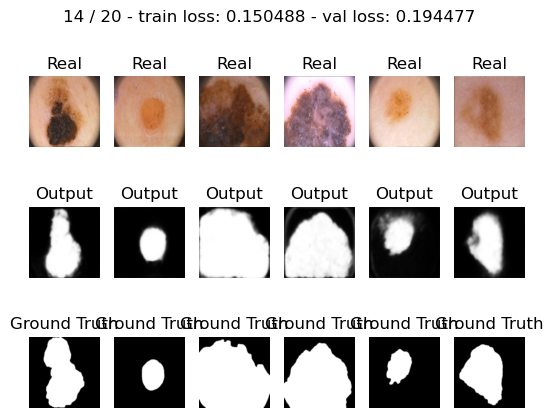

* Epoch 15/20
 - train loss: 0.1896 - val loss: 0.1613
Validation loss did not improve. Patience counter: 5/5
Early stopping triggered. Training stopped.


In [13]:
train_with_validation(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, val_loader, test_loader)